# **🏠 부동산 실거래가 Baseline code**
> 부동산 실거래가 예측 대회에 오신 여러분 환영합니다! 🎉     
> 아래 baseline에서는 RandomForest를 활용해 ML 방법론들을 실제 대회에 적용해보도록 하겠습니다.
> 강의는 google colab으로 실행하였기에 아래의 베이스라인 코드와는 일부 차이가 있을 수 있습니다. 

## Contents
- Library Import
- Data Load
- Data Preprocessing
- Feature Engineering
- Model Training
- Inference
- Output File Save


## 1. Library Import
- 필요한 라이브러리를 불러옵니다.

In [1]:
%pip install eli5==0.13.0

# 한글 폰트 사용을 위한 라이브러리입니다.
!apt-get install -y fonts-nanum

Note: you may need to restart the kernel to use updated packages.
Reading package lists... Done
Building dependency tree       
Reading state information... Done
fonts-nanum is already the newest version (20180306-3).
0 upgraded, 0 newly installed, 0 to remove and 50 not upgraded.


In [2]:
KAKAO_API_KEY = 'cb6d5d8a448c1a2344a636a2888775aa'

In [3]:
# visualization
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
fe = fm.FontEntry(
    fname=r'/usr/share/fonts/truetype/nanum/NanumGothic.ttf', # ttf 파일이 저장되어 있는 경로
    name='NanumBarunGothic')                        # 이 폰트의 원하는 이름 설정
fm.fontManager.ttflist.insert(0, fe)              # Matplotlib에 폰트 추가
plt.rcParams.update({'font.size': 10, 'font.family': 'NanumBarunGothic'}) # 폰트 설정
plt.rc('font', family='NanumBarunGothic')
import seaborn as sns

# utils
import pandas as pd
import numpy as np
from tqdm import tqdm
import pickle
import warnings;warnings.filterwarnings('ignore')
from sklearn.neighbors import BallTree

# Model
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import RandomForestRegressor
from sklearn import metrics

import eli5
from eli5.sklearn import PermutationImportance

# Network
import requests
import json

## 2. Data Load

#### 2.1. 데이터 로드

In [4]:
# 필요한 데이터를 load 하겠습니다. 경로는 환경에 맞게 지정해주면 됩니다.
train_path = '/data/ephemeral/home/train.csv'
test_path  = '/data/ephemeral/home/test.csv'
dt = pd.read_csv(train_path)
dt_test = pd.read_csv(test_path)

In [5]:
# bus_path = '/data/ephemeral/home/bus_feature.csv'
# subway_path = '/data/ephemeral/home/subway_feature.csv'
# dt_bus = pd.read_csv(bus_path)
# dt_subway = pd.read_csv(subway_path)

In [6]:
# address_path = '/data/ephemeral/home/address_data.csv'
# dt_addr = pd.read_csv(address_path)

In [7]:
display(len(dt))
# display(len(dt_addr))

1118822

In [8]:
# Train data와 Test data shape은 아래와 같습니다.
print('Train data shape : ', dt.shape, 'Test data shape : ', dt_test.shape)

Train data shape :  (1118822, 52) Test data shape :  (9272, 51)


In [9]:
# Train과 Test data를 살펴보겠습니다.
display(dt.head(1))
display(dt_test.head(1))      # 부동산 실거래가(=Target) column이 제외된 모습입니다.

,시군구,번지,본번,부번,아파트명,전용면적(㎡),계약년월,계약일,층,건축년도,...,건축면적,주차대수,기타/의무/임대/임의=1/2/3/4,단지승인일,사용허가여부,관리비 업로드,좌표X,좌표Y,단지신청일,target
0,서울특별시 강남구 개포동,658-1,658.0,1.0,개포6차우성,79.97,201712,8,3,1987,...,4858.0,262.0,임의,2022-11-17 13:00:29.0,Y,N,127.05721,37.476763,2022-11-17 10:19:06.0,124000


,시군구,번지,본번,부번,아파트명,전용면적(㎡),계약년월,계약일,층,건축년도,...,청소비관리형태,건축면적,주차대수,기타/의무/임대/임의=1/2/3/4,단지승인일,사용허가여부,관리비 업로드,좌표X,좌표Y,단지신청일
0,서울특별시 강남구 개포동,658-1,658.0,1.0,개포6차우성,79.97,202307,26,5,1987,...,직영,4858.0,262.0,임의,2022-11-17 13:00:29.0,Y,N,127.05721,37.476763,2022-11-17 10:19:06.0


## 3. Data Preprocessing

- 모델링 전에 데이터 내 결측치, 이상치 등을 제거하고 범주형과 연속형 변수를 살펴보도록 하겠습니다!
- 먼저, 용이한 전처리를 위해 train과 test data를 합친 하나의 데이터로 진행하도록 하겠습니다.

In [10]:
# train/test 구분을 위한 칼럼을 하나 만들어 줍니다.
dt['is_test'] = 0
dt_test['is_test'] = 1
concat = pd.concat([dt, dt_test])     # 하나의 데이터로 만들어줍니다.

In [11]:
concat['is_test'].value_counts()      # train과 test data가 하나로 합쳐진 것을 확인할 수 있습니다.

0    1118822
1       9272
Name: is_test, dtype: int64

In [12]:
display(concat.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1128094 entries, 0 to 9271
Data columns (total 53 columns):
 #   Column                  Non-Null Count    Dtype  
---  ------                  --------------    -----  
 0   시군구                     1128094 non-null  object 
 1   번지                      1127867 non-null  object 
 2   본번                      1128019 non-null  float64
 3   부번                      1128019 non-null  float64
 4   아파트명                    1125958 non-null  object 
 5   전용면적(㎡)                 1128094 non-null  float64
 6   계약년월                    1128094 non-null  int64  
 7   계약일                     1128094 non-null  int64  
 8   층                       1128094 non-null  int64  
 9   건축년도                    1128094 non-null  int64  
 10  도로명                     1128094 non-null  object 
 11  해제사유발생일                 6195 non-null     float64
 12  등기신청일자                  1128094 non-null  object 
 13  거래유형                    1128094 non-null  object 
 14  중개사소재

None

In [13]:
# 칼럼 이름을 쉽게 바꿔주겠습니다. 다른 칼럼도 사용에 따라 바꿔주셔도 됩니다!
concat = concat.rename(columns={'전용면적(㎡)':'전용면적'})

In [14]:
display(dt.head(1))

,시군구,번지,본번,부번,아파트명,전용면적(㎡),계약년월,계약일,층,건축년도,...,주차대수,기타/의무/임대/임의=1/2/3/4,단지승인일,사용허가여부,관리비 업로드,좌표X,좌표Y,단지신청일,target,is_test
0,서울특별시 강남구 개포동,658-1,658.0,1.0,개포6차우성,79.97,201712,8,3,1987,...,262.0,임의,2022-11-17 13:00:29.0,Y,N,127.05721,37.476763,2022-11-17 10:19:06.0,124000,0


### 3.1. 결측치 탐색 및 보간
- 결측치를 처리할 때 많이 쓰는 방법은 삭제(Deletion)과 대체(Imputation) 입니다.
- 

In [15]:
display(len(concat))
# display(len(dt_addr))

1128094

In [16]:
display(concat[['시군구','번지','본번','도로명']].head(2))
display(concat[['시군구','번지','본번','도로명']].tail(2))

,시군구,번지,본번,도로명
0,서울특별시 강남구 개포동,658-1,658.0,언주로 3
1,서울특별시 강남구 개포동,658-1,658.0,언주로 3


,시군구,번지,본번,도로명
9270,서울특별시 중랑구 신내동,816,816.0,신내역로1길 85
9271,서울특별시 중랑구 신내동,816,816.0,신내역로1길 85


In [17]:
# 중복된 행 여부를 나타내는 불리언 시리즈 생성
duplicate_rows = concat.duplicated(subset=['도로명'])

# 중복된 행의 수 계산
num_duplicates = duplicate_rows.sum()

print(f"'도로명'을 기준으로 중복된 행의 수: {num_duplicates}개")
print(f"전체에서 중복된 데이터를 뺀 개수: {len(concat) - num_duplicates}개")

'도로명'을 기준으로 중복된 행의 수: 1118849개
전체에서 중복된 데이터를 뺀 개수: 9245개


In [18]:
unique_addr_df = concat[['시군구', '번지', '도로명', '아파트명', '좌표X', '좌표Y']].drop_duplicates(subset='도로명')
display(len(unique_addr_df))
display(unique_addr_df.head())

9245

,시군구,번지,도로명,아파트명,좌표X,좌표Y
0,서울특별시 강남구 개포동,658-1,언주로 3,개포6차우성,127.057210,37.476763
12,서울특별시 강남구 개포동,652,개포로 307,개포우성3차,127.055990,37.483894
25,서울특별시 강남구 개포동,12-2,개포로109길 69,개포자이,127.076624,37.496296
38,서울특별시 강남구 개포동,141,개포로 310,개포주공1단지,127.058521,37.480002
44,서울특별시 강남구 개포동,141,선릉로 7,개포주공1단지,127.058521,37.480002


In [19]:
display(unique_addr_df.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 9245 entries, 0 to 9050
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   시군구     9245 non-null   object 
 1   번지      9243 non-null   object 
 2   도로명     9245 non-null   object 
 3   아파트명    8964 non-null   object 
 4   좌표X     821 non-null    float64
 5   좌표Y     821 non-null    float64
dtypes: float64(2), object(4)
memory usage: 505.6+ KB


None

In [20]:
# # 카카오 함수 호출 정의
# def get_lat_lng(address):
#     url = 'https://dapi.kakao.com/v2/local/search/address.json'
#     headers = {"Authorization": f"KakaoAK {KAKAO_API_KEY}"}
#     params = {'query': address}
    
#     response = requests.get(url, headers=headers, params=params)
    
#     if response.status_code == 200:
#         result = response.json()
#         if result['documents']:
#             y = result['documents'][0]['y']
#             x = result['documents'][0]['x']
#             # documents 리턴값 출력
#             # display(result['documents'])
#             return y, x  # 위도(y), 경도(x)
#     return None, None

In [21]:
# # 유효한 주소에 대해 위도와 경도 가져오기
# pre_addr = None
# pre_lat, pre_lng = None, None

# for i, row in tqdm(unique_addr_df.iterrows()):
#     address = row['도로명']  
#     if pd.isna(row['좌표X']):   
#         # if address == pre_addr:
#         #     lat, lng = pre_lat, pre_lng        
#         # else:
#         #     # display('호출')
#         #     lat, lng = get_lat_lng(address)
#         #     pre_addr = address
#         #     pre_lat, pre_lng = lat, lng      

#         lat, lng = get_lat_lng(address)
#         if lat is not None and lng is not None:
#             pre_addr = address
#             pre_lat, pre_lng = lat, lng
#         else:
#             address = f"{row['시군구']} {row['번지']}"
#             lat, lng = get_lat_lng(address)
#             if lat is not None and lng is not None:
#                 pre_addr = address
#                 pre_lat, pre_lng = lat, lng
#             else:
#                 address = f"{row['시군구']}"
#                 lat, lng = get_lat_lng(address)
#                 if lat is not None and lng is not None:
#                     pre_addr = address
#                     pre_lat, pre_lng = lat, lng
#                 else:
#                     print(f"좌표를 가져오지 못했습니다: {address}")
#                     lat, lng = pre_lat, pre_lng
        
#         # 값 세팅
#         unique_addr_df.at[i,'좌표Y'] = lat       
#         unique_addr_df.at[i,'좌표X'] = lng

# display(unique_addr_df)

In [22]:
concat.isnull().sum()

시군구                             0
번지                            227
본번                             75
부번                             75
아파트명                         2136
전용면적                            0
계약년월                            0
계약일                             0
층                               0
건축년도                            0
도로명                             0
해제사유발생일                   1121899
등기신청일자                          0
거래유형                            0
중개사소재지                          0
k-단지분류(아파트,주상복합등등)         877273
k-전화번호                     876850
k-팩스번호                     879348
단지소개기존clob                1058958
k-세대타입(분양형태)               876125
k-관리방식                     876125
k-복도유형                     876454
k-난방방식                     876125
k-전체동수                     877207
k-전체세대수                    876125
k-건설사(시공사)                 877637
k-시행사                      877834
k-사용검사일-사용승인일              876259
k-연면적                      876125
k-주거전용면적      

In [23]:
# # 결과 데이터프레임을 CSV 파일로 저장 
# unique_addr_df.to_csv('../unique_address.csv', index=False) 
# print("CSV 파일 저장이 완료되었습니다.")

In [24]:
unique_addr_path = '../unique_address.csv'
duplicated_addr_df = pd.read_csv(unique_addr_path)

In [25]:
display(duplicated_addr_df.tail())

,시군구,번지,도로명,아파트명,좌표X,좌표Y
9240,서울특별시 동작구 흑석동,253-89,서달로 90,흑석리버파크자이,126.963347,37.502463
9241,서울특별시 마포구 신수동,400-1,토정로17길 6,신수동르끌레브,126.935927,37.544843
9242,서울특별시 성동구 송정동,67-5,송정길 32,히페리온리버팰리스,127.063395,37.548729
9243,서울특별시 중구 인현동2가,240,마른내로 79,세운푸르지오헤리시티,126.996600,37.564541
9244,서울특별시 중구 입정동,277,을지로15길 31,힐스테이트세운센트럴1단지,126.993126,37.568096


In [26]:
display(concat.index)
display(unique_addr_df.index)
duplicated_addr_df.index = unique_addr_df.index
display(duplicated_addr_df.index)
# unique_addr_df.index = concat.index
# display(concat.index)
# display(unique_addr_df.index)

Int64Index([   0,    1,    2,    3,    4,    5,    6,    7,    8,    9,
            ...
            9262, 9263, 9264, 9265, 9266, 9267, 9268, 9269, 9270, 9271],
           dtype='int64', length=1128094)

Int64Index([   0,   12,   25,   38,   44,  204,  242,  289,  309,  324,
            ...
            1274, 1370, 2138, 2429, 3161, 4581, 4738, 6087, 8880, 9050],
           dtype='int64', length=9245)

Int64Index([   0,   12,   25,   38,   44,  204,  242,  289,  309,  324,
            ...
            1274, 1370, 2138, 2429, 3161, 4581, 4738, 6087, 8880, 9050],
           dtype='int64', length=9245)

In [27]:
# '도로명' 컬럼이 문자열 타입인지 확인하고 통일합니다.
concat['도로명'] = concat['도로명'].astype(str)
duplicated_addr_df['도로명'] = duplicated_addr_df['도로명'].astype(str)

In [28]:
# 서브 데이터프레임에서 '도로명'을 인덱스로 설정합니다.
duplicated_addr_df.set_index('도로명', inplace=True)

In [29]:
display(duplicated_addr_df.tail())

,시군구,번지,아파트명,좌표X,좌표Y
도로명,,,,,
서달로 90,서울특별시 동작구 흑석동,253-89,흑석리버파크자이,126.963347,37.502463
토정로17길 6,서울특별시 마포구 신수동,400-1,신수동르끌레브,126.935927,37.544843
송정길 32,서울특별시 성동구 송정동,67-5,히페리온리버팰리스,127.063395,37.548729
마른내로 79,서울특별시 중구 인현동2가,240,세운푸르지오헤리시티,126.996600,37.564541
을지로15길 31,서울특별시 중구 입정동,277,힐스테이트세운센트럴1단지,126.993126,37.568096


In [30]:
# 서브 데이터프레임에서 '좌표X'와 '좌표Y'의 딕셔너리 생성
coord_x_map = duplicated_addr_df['좌표X']
coord_y_map = duplicated_addr_df['좌표Y']

# 메인 데이터프레임의 '좌표X' 결측치 채우기
concat['좌표X'] = concat['좌표X'].fillna(concat['도로명'].map(coord_x_map))

# 메인 데이터프레임의 '좌표Y' 결측치 채우기
concat['좌표Y'] = concat['좌표Y'].fillna(concat['도로명'].map(coord_y_map))

In [31]:
# 결측치가 있는 행 확인
missing_coords = concat[concat['좌표X'].isnull() | concat['좌표Y'].isnull()]
print(missing_coords)

Empty DataFrame
Columns: [시군구, 번지, 본번, 부번, 아파트명, 전용면적, 계약년월, 계약일, 층, 건축년도, 도로명, 해제사유발생일, 등기신청일자, 거래유형, 중개사소재지, k-단지분류(아파트,주상복합등등), k-전화번호, k-팩스번호, 단지소개기존clob, k-세대타입(분양형태), k-관리방식, k-복도유형, k-난방방식, k-전체동수, k-전체세대수, k-건설사(시공사), k-시행사, k-사용검사일-사용승인일, k-연면적, k-주거전용면적, k-관리비부과면적, k-전용면적별세대현황(60㎡이하), k-전용면적별세대현황(60㎡~85㎡이하), k-85㎡~135㎡이하, k-135㎡초과, k-홈페이지, k-등록일자, k-수정일자, 고용보험관리번호, 경비비관리형태, 세대전기계약방법, 청소비관리형태, 건축면적, 주차대수, 기타/의무/임대/임의=1/2/3/4, 단지승인일, 사용허가여부, 관리비 업로드, 좌표X, 좌표Y, 단지신청일, target, is_test]
Index: []

[0 rows x 53 columns]


In [32]:
concat[['아파트명']] = concat[['아파트명']].fillna('이름없음')

In [33]:
# 실제로 결측치라고 표시는 안되어있지만 아무 의미도 갖지 않는 element들이 아래와 같이 존재합니다.
# 아래 3가지의 경우 모두 아무 의미도 갖지 않는 element가 포함되어 있습니다.
display(concat['등기신청일자'].value_counts())

            1111271
20230630        585
20230831        496
20230428        394
20230731        374
             ...   
20230105          3
20230125          3
20230109          1
20230102          1
20230104          1
Name: 등기신청일자, Length: 182, dtype: int64

In [34]:
display(concat['거래유형'].value_counts())

-       1086451
중개거래      38123
직거래        3520
Name: 거래유형, dtype: int64

In [35]:
display(concat['중개사소재지'].value_counts())

-                    1090013
서울 노원구                  2627
서울 송파구                  2540
서울 강남구                  2508
서울 강동구                  2038
                      ...   
서울 강북구, 서울 양천구             1
경기 남양주시, 경기 성남수정구          1
서울 송파구, 인천 계양구             1
경기 연천군, 서울 송파구             1
서울 중랑구, 인천 부평구             1
Name: 중개사소재지, Length: 739, dtype: int64

In [36]:
# 위 처럼 아무 의미도 갖지 않는 칼럼은 결측치와 같은 역할을 하므로, np.nan으로 채워 결측치로 인식되도록 합니다.
concat['등기신청일자'] = concat['등기신청일자'].replace(' ', np.nan)
concat['거래유형'] = concat['거래유형'].replace('-', np.nan)
concat['중개사소재지'] = concat['중개사소재지'].replace('-', np.nan)

In [37]:
concat.isnull().sum()

시군구                             0
번지                            227
본번                             75
부번                             75
아파트명                            0
전용면적                            0
계약년월                            0
계약일                             0
층                               0
건축년도                            0
도로명                             0
해제사유발생일                   1121899
등기신청일자                    1111271
거래유형                      1086451
중개사소재지                    1090013
k-단지분류(아파트,주상복합등등)         877273
k-전화번호                     876850
k-팩스번호                     879348
단지소개기존clob                1058958
k-세대타입(분양형태)               876125
k-관리방식                     876125
k-복도유형                     876454
k-난방방식                     876125
k-전체동수                     877207
k-전체세대수                    876125
k-건설사(시공사)                 877637
k-시행사                      877834
k-사용검사일-사용승인일              876259
k-연면적                      876125
k-주거전용면적      

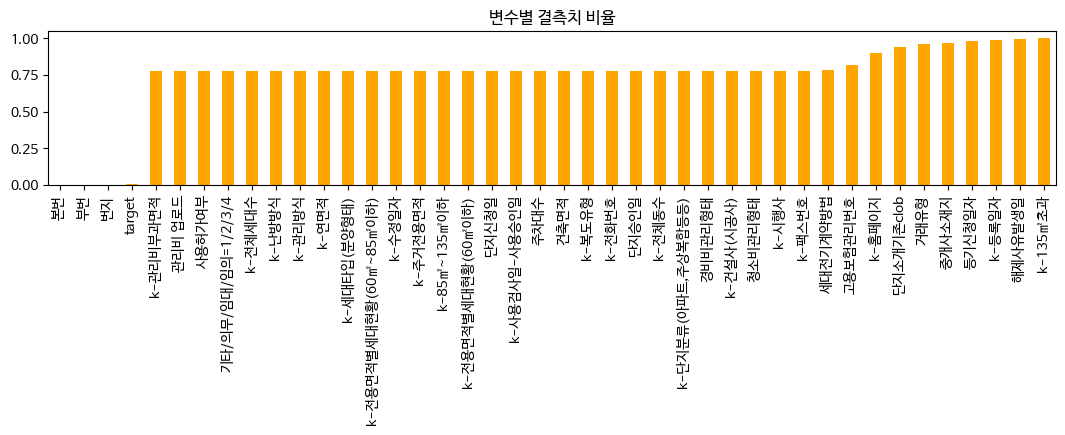

In [38]:
# 변수별 결측치의 비율을 plot으로 그려보면 아래와 같습니다.
fig = plt.figure(figsize=(13, 2))
missing = concat.isnull().sum() / concat.shape[0]
missing = missing[missing > 0]
missing.sort_values(inplace=True)
missing.plot.bar(color='orange')
plt.title('변수별 결측치 비율')
plt.show()

- 위 그래프에서 볼 수 있다시피 결측치가 100만개 이상인 칼럼들은 결측치가 해당 칼럼의 element 중 90% 이상을 차지하는 상황이 됩니다.
- 따라서 본 Baseline 에서는 이 칼럼은 예측에 도움이 되지 않는다고 판단해 삭제해주도록 하겠습니다.

In [39]:
# Null값이 100만개 이상인 칼럼은 삭제해보도록 하겠습니다.
print("* 결측치가 100만개 이하인 변수들 :", list(concat.columns[concat.isnull().sum() <= 1000000]))     # 남겨질 변수들은 아래와 같습니다.
print("* 결측치가 100만개 이상인 변수들 :", list(concat.columns[concat.isnull().sum() >= 1000000]))

* 결측치가 100만개 이하인 변수들 : ['시군구', '번지', '본번', '부번', '아파트명', '전용면적', '계약년월', '계약일', '층', '건축년도', '도로명', 'k-단지분류(아파트,주상복합등등)', 'k-전화번호', 'k-팩스번호', 'k-세대타입(분양형태)', 'k-관리방식', 'k-복도유형', 'k-난방방식', 'k-전체동수', 'k-전체세대수', 'k-건설사(시공사)', 'k-시행사', 'k-사용검사일-사용승인일', 'k-연면적', 'k-주거전용면적', 'k-관리비부과면적', 'k-전용면적별세대현황(60㎡이하)', 'k-전용면적별세대현황(60㎡~85㎡이하)', 'k-85㎡~135㎡이하', 'k-수정일자', '고용보험관리번호', '경비비관리형태', '세대전기계약방법', '청소비관리형태', '건축면적', '주차대수', '기타/의무/임대/임의=1/2/3/4', '단지승인일', '사용허가여부', '관리비 업로드', '좌표X', '좌표Y', '단지신청일', 'target', 'is_test']
* 결측치가 100만개 이상인 변수들 : ['해제사유발생일', '등기신청일자', '거래유형', '중개사소재지', '단지소개기존clob', 'k-135㎡초과', 'k-홈페이지', 'k-등록일자']


In [40]:
# 위에서 결측치가 100만개 이하인 변수들만 골라 새로운 concat_select 객체로 저장해줍니다.
selected = list(concat.columns[concat.isnull().sum() <= 1000000])
concat_select = concat[selected]

In [41]:
display(concat_select.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1128094 entries, 0 to 9271
Data columns (total 45 columns):
 #   Column                  Non-Null Count    Dtype  
---  ------                  --------------    -----  
 0   시군구                     1128094 non-null  object 
 1   번지                      1127867 non-null  object 
 2   본번                      1128019 non-null  float64
 3   부번                      1128019 non-null  float64
 4   아파트명                    1128094 non-null  object 
 5   전용면적                    1128094 non-null  float64
 6   계약년월                    1128094 non-null  int64  
 7   계약일                     1128094 non-null  int64  
 8   층                       1128094 non-null  int64  
 9   건축년도                    1128094 non-null  int64  
 10  도로명                     1128094 non-null  object 
 11  k-단지분류(아파트,주상복합등등)      250821 non-null   object 
 12  k-전화번호                  251244 non-null   object 
 13  k-팩스번호                  248746 non-null   object 
 14  k-세대타

None

In [42]:
concat_select.isnull().sum()     # 결측치가 100만개 초과인 칼럼이 제거된 모습은 아래와 같습니다.
# target변수는 test dataset 개수만큼(9272) 결측치가 존재함을 확인할 수 있습니다.

시군구                            0
번지                           227
본번                            75
부번                            75
아파트명                           0
전용면적                           0
계약년월                           0
계약일                            0
층                              0
건축년도                           0
도로명                            0
k-단지분류(아파트,주상복합등등)        877273
k-전화번호                    876850
k-팩스번호                    879348
k-세대타입(분양형태)              876125
k-관리방식                    876125
k-복도유형                    876454
k-난방방식                    876125
k-전체동수                    877207
k-전체세대수                   876125
k-건설사(시공사)                877637
k-시행사                     877834
k-사용검사일-사용승인일             876259
k-연면적                     876125
k-주거전용면적                  876170
k-관리비부과면적                 876125
k-전용면적별세대현황(60㎡이하)        876170
k-전용면적별세대현황(60㎡~85㎡이하)    876170
k-85㎡~135㎡이하              876170
k-수정일자                    876170
고용보험관리번호  

In [43]:
# 연속형 변수는 선형보간을 해주고, 범주형변수는 알수없기에 “unknown”이라고 임의로 보간해 주겠습니다.
concat_select.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1128094 entries, 0 to 9271
Data columns (total 45 columns):
 #   Column                  Non-Null Count    Dtype  
---  ------                  --------------    -----  
 0   시군구                     1128094 non-null  object 
 1   번지                      1127867 non-null  object 
 2   본번                      1128019 non-null  float64
 3   부번                      1128019 non-null  float64
 4   아파트명                    1128094 non-null  object 
 5   전용면적                    1128094 non-null  float64
 6   계약년월                    1128094 non-null  int64  
 7   계약일                     1128094 non-null  int64  
 8   층                       1128094 non-null  int64  
 9   건축년도                    1128094 non-null  int64  
 10  도로명                     1128094 non-null  object 
 11  k-단지분류(아파트,주상복합등등)      250821 non-null   object 
 12  k-전화번호                  251244 non-null   object 
 13  k-팩스번호                  248746 non-null   object 
 14  k-세대타

In [44]:
# 본번, 부번의 경우 float로 되어있지만 범주형 변수의 의미를 가지므로 object(string) 형태로 바꾸어주고 아래 작업을 진행하겠습니다.
concat_select['본번'] = concat_select['본번'].astype('str')
concat_select['부번'] = concat_select['부번'].astype('str')
concat_select['좌표X'] = concat_select['좌표X'].astype('float')
concat_select['좌표Y'] = concat_select['좌표Y'].astype('float')

In [45]:
# 먼저, 연속형 변수와 범주형 변수를 위 info에 따라 분리해주겠습니다.
continuous_columns = []
categorical_columns = []

for column in concat_select.columns:
    if pd.api.types.is_numeric_dtype(concat_select[column]):
        continuous_columns.append(column)
    else:
        categorical_columns.append(column)

print("연속형 변수:", continuous_columns)
print("범주형 변수:", categorical_columns)

연속형 변수: ['전용면적', '계약년월', '계약일', '층', '건축년도', 'k-전체동수', 'k-전체세대수', 'k-연면적', 'k-주거전용면적', 'k-관리비부과면적', 'k-전용면적별세대현황(60㎡이하)', 'k-전용면적별세대현황(60㎡~85㎡이하)', 'k-85㎡~135㎡이하', '건축면적', '주차대수', '좌표X', '좌표Y', 'target', 'is_test']
범주형 변수: ['시군구', '번지', '본번', '부번', '아파트명', '도로명', 'k-단지분류(아파트,주상복합등등)', 'k-전화번호', 'k-팩스번호', 'k-세대타입(분양형태)', 'k-관리방식', 'k-복도유형', 'k-난방방식', 'k-건설사(시공사)', 'k-시행사', 'k-사용검사일-사용승인일', 'k-수정일자', '고용보험관리번호', '경비비관리형태', '세대전기계약방법', '청소비관리형태', '기타/의무/임대/임의=1/2/3/4', '단지승인일', '사용허가여부', '관리비 업로드', '단지신청일']


- 연속형 변수와 범주형 변수가 알맞게 나누어졌는지 확인해보고, 이제 각각 보간을 진행합니다.

In [46]:
# 범주형 변수에 대한 보간
concat_select[categorical_columns] = concat_select[categorical_columns].fillna('NULL')

# 연속형 변수에 대한 보간 (선형 보간)
concat_select[continuous_columns] = concat_select[continuous_columns].interpolate(method='linear', axis=0)

In [47]:
concat_select.isnull().sum()         # 결측치가 보간된 모습을 확인해봅니다.

시군구                       0
번지                        0
본번                        0
부번                        0
아파트명                      0
전용면적                      0
계약년월                      0
계약일                       0
층                         0
건축년도                      0
도로명                       0
k-단지분류(아파트,주상복합등등)        0
k-전화번호                    0
k-팩스번호                    0
k-세대타입(분양형태)              0
k-관리방식                    0
k-복도유형                    0
k-난방방식                    0
k-전체동수                    0
k-전체세대수                   0
k-건설사(시공사)                0
k-시행사                     0
k-사용검사일-사용승인일             0
k-연면적                     0
k-주거전용면적                  0
k-관리비부과면적                 0
k-전용면적별세대현황(60㎡이하)        0
k-전용면적별세대현황(60㎡~85㎡이하)    0
k-85㎡~135㎡이하              0
k-수정일자                    0
고용보험관리번호                  0
경비비관리형태                   0
세대전기계약방법                  0
청소비관리형태                   0
건축면적                      0
주차대수                

- Baseline에서는 단순 결측치들을 제거하거나 보간했지만,
EDA를 통해 변수들의 흐름을 조금 더 파악하고 더 나은 interpolation 등의 방법을 고려해볼 수 있을 것 같습니다.

### 3.2. 이상치 처리
- 이번엔 이상치를 처리해봅시다.
- 이상치를 처리하는 방법은 IQR, Z-score 등 다양한 방법이 있습니다. 가장 쉽고 직관적으로 접근하는 방법은 기본 통계치를 이용하는 것입니다.
- 본 baseline에서는 IQR를 이용한 방법을 사용하겠습니다.

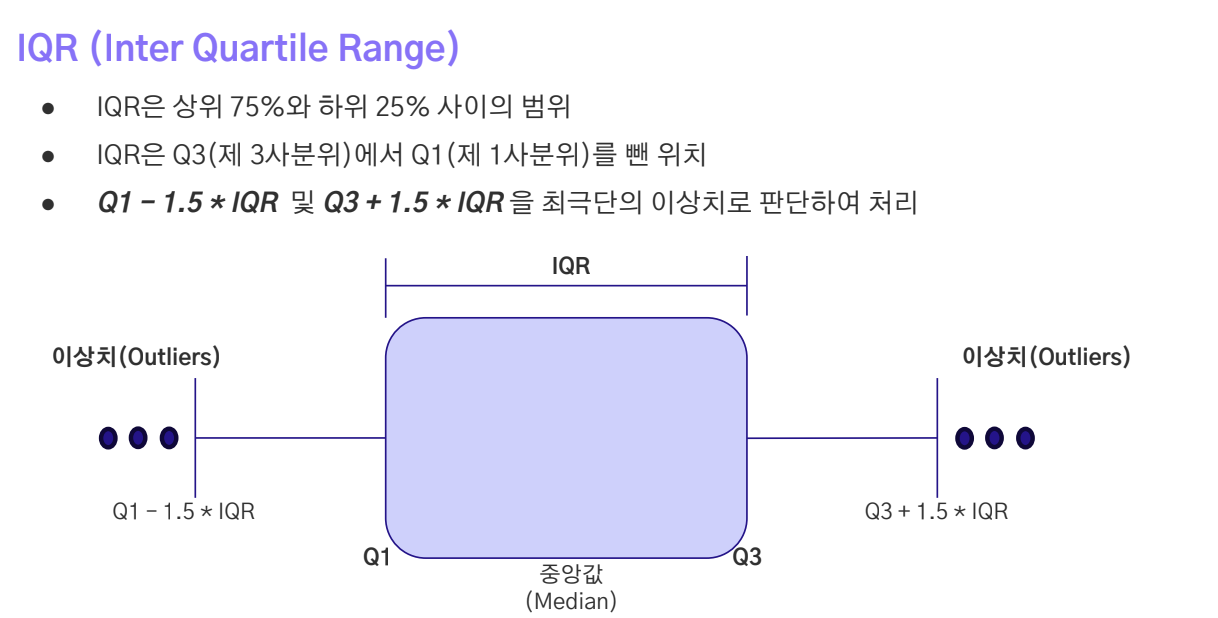

In [48]:
# 이상치 제거 이전의 shape은 아래와 같습니다.
print(concat_select.shape)

(1128094, 45)


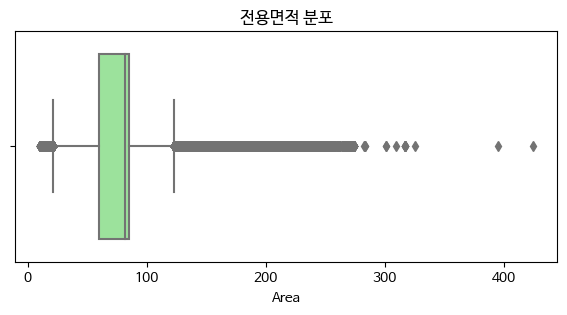

In [49]:
# 대표적인 연속형 변수인 “전용 면적” 변수 관련한 분포를 먼저 살펴보도록 하겠습니다.
fig = plt.figure(figsize=(7, 3))
sns.boxplot(data = concat_select, x = "전용면적", color="lightgreen")
plt.title("전용면적 분포")
plt.xlabel('Area')
plt.show()

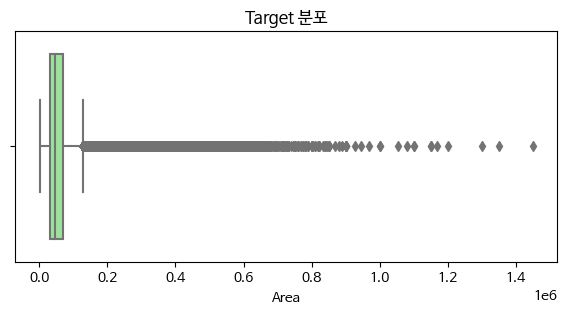

In [50]:
# 대표적인 연속형 변수인 “전용 면적” 변수 관련한 분포를 먼저 살펴보도록 하겠습니다.
fig = plt.figure(figsize=(7, 3))
sns.boxplot(data = dt, x = "target", color="lightgreen")
plt.title("Target 분포")
plt.xlabel('Area')
plt.show()

In [51]:
# 이상치 제거 방법에는 IQR을 이용하겠습니다.
def remove_outliers_iqr(dt, column_name):
    df = dt.query('is_test == 0')       # train data 내에 있는 이상치만 제거하도록 하겠습니다.
    df_test = dt.query('is_test == 1')

    Q1 = df[column_name].quantile(0.25)
    Q3 = df[column_name].quantile(0.75)
    IQR = Q3 - Q1

    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    df = df[(df[column_name] >= lower_bound) & (df[column_name] <= upper_bound)]

    result = pd.concat([df, df_test])   # test data와 다시 합쳐주겠습니다.
    return result

In [52]:
# 위 방법으로 전용 면적에 대한 이상치를 제거해보겠습니다.
concat_select = remove_outliers_iqr(concat_select, '전용면적')

In [53]:
# 이상치 제거 후의 shape은 아래와 같습니다. 약 10만개의 데이터가 제거된 모습을 확인할 수 있습니다.
print(concat_select.shape)

(1038846, 45)


In [54]:
concat_select['is_test'].value_counts()     # 또한, train data만 제거되었습니다.

0    1029574
1       9272
Name: is_test, dtype: int64

## 4. Feature Engineering
- 이제 파생변수를 만들어보도록 하겠습니다.
- 파생 변수는 도메인 지식에 기반해 제작하는 것이 중요합니다.
- 주택의 가격을 예측하는 문제이기 때문에 약간의 부동산 지식을 기반으로 파생 변수를 만들어 보도록 하겠습니다.

In [55]:
# 시군구, 년월 등 분할할 수 있는 변수들은 세부사항 고려를 용이하게 하기 위해 모두 분할해 주겠습니다.
concat_select['구'] = concat_select['시군구'].map(lambda x : x.split()[1])
concat_select['동'] = concat_select['시군구'].map(lambda x : x.split()[2])
del concat_select['시군구']

concat_select['계약년'] = concat_select['계약년월'].astype('str').map(lambda x : x[:4])
concat_select['계약월'] = concat_select['계약년월'].astype('str').map(lambda x : x[4:])
del concat_select['계약년월']

In [56]:
concat_select.columns

Index(['번지', '본번', '부번', '아파트명', '전용면적', '계약일', '층', '건축년도', '도로명',
       'k-단지분류(아파트,주상복합등등)', 'k-전화번호', 'k-팩스번호', 'k-세대타입(분양형태)', 'k-관리방식',
       'k-복도유형', 'k-난방방식', 'k-전체동수', 'k-전체세대수', 'k-건설사(시공사)', 'k-시행사',
       'k-사용검사일-사용승인일', 'k-연면적', 'k-주거전용면적', 'k-관리비부과면적', 'k-전용면적별세대현황(60㎡이하)',
       'k-전용면적별세대현황(60㎡~85㎡이하)', 'k-85㎡~135㎡이하', 'k-수정일자', '고용보험관리번호',
       '경비비관리형태', '세대전기계약방법', '청소비관리형태', '건축면적', '주차대수', '기타/의무/임대/임의=1/2/3/4',
       '단지승인일', '사용허가여부', '관리비 업로드', '좌표X', '좌표Y', '단지신청일', 'target',
       'is_test', '구', '동', '계약년', '계약월'],
      dtype='object')

- 서울의 집값은 강남, 강북 여부에 따라 차이가 많이 난다는 사실은 많이 알려진 사실입니다.
- 따라서 강남/강북의 여부에 따라 파생변수를 생성해주도록 하겠습니다.

In [57]:
all = list(concat_select['구'].unique())
gangnam = ['강서구', '영등포구', '동작구', '서초구', '강남구', '송파구', '강동구']
gangbuk = [x for x in all if x not in gangnam]

assert len(all) == len(gangnam) + len(gangbuk)       # 알맞게 분리되었는지 체크합니다.

In [58]:
# 강남의 여부를 체크합니다.
is_gangnam = []
for x in concat_select['구'].tolist() :
  if x in gangnam :
    is_gangnam.append(1)
  else :
    is_gangnam.append(0)

# 파생변수를 하나 만릅니다.
concat_select['강남여부'] = is_gangnam

In [59]:
concat_select.columns

Index(['번지', '본번', '부번', '아파트명', '전용면적', '계약일', '층', '건축년도', '도로명',
       'k-단지분류(아파트,주상복합등등)', 'k-전화번호', 'k-팩스번호', 'k-세대타입(분양형태)', 'k-관리방식',
       'k-복도유형', 'k-난방방식', 'k-전체동수', 'k-전체세대수', 'k-건설사(시공사)', 'k-시행사',
       'k-사용검사일-사용승인일', 'k-연면적', 'k-주거전용면적', 'k-관리비부과면적', 'k-전용면적별세대현황(60㎡이하)',
       'k-전용면적별세대현황(60㎡~85㎡이하)', 'k-85㎡~135㎡이하', 'k-수정일자', '고용보험관리번호',
       '경비비관리형태', '세대전기계약방법', '청소비관리형태', '건축면적', '주차대수', '기타/의무/임대/임의=1/2/3/4',
       '단지승인일', '사용허가여부', '관리비 업로드', '좌표X', '좌표Y', '단지신청일', 'target',
       'is_test', '구', '동', '계약년', '계약월', '강남여부'],
      dtype='object')

- 또한 신축인지, 구축인지의 여부도 실거래가에 큰 영향을 줄 수 있습니다.
- 따라서 건축년도에 따라 파생변수를 제작해주도록 하겠습니다.

In [60]:
# 건축년도 분포는 아래와 같습니다. 특히 2005년이 Q3에 해당합니다.
# 2009년 이후에 지어진 건물은 10%정도 되는 것을 확인할 수 있습니다.
concat_select['건축년도'].describe(percentiles = [0.1, 0.25, 0.5, 0.75, 0.8, 0.9])

count    1.038846e+06
mean     1.998583e+03
std      9.132471e+00
min      1.961000e+03
10%      1.987000e+03
25%      1.992000e+03
50%      2.000000e+03
75%      2.005000e+03
80%      2.006000e+03
90%      2.009000e+03
max      2.023000e+03
Name: 건축년도, dtype: float64

In [61]:
# 따라서 2009년 이후에 지어졌으면 비교적 신축이라고 판단하고, 신축 여부 변수를 제작해보도록 하겠습니다.
concat_select['신축여부'] = concat_select['건축년도'].apply(lambda x: 1 if x >= 2009 else 0)

In [62]:
concat_select.head(1)       # 최종 데이터셋은 아래와 같습니다.

,번지,본번,부번,아파트명,전용면적,계약일,층,건축년도,도로명,"k-단지분류(아파트,주상복합등등)",...,좌표Y,단지신청일,target,is_test,구,동,계약년,계약월,강남여부,신축여부
0,658-1,658.0,1.0,개포6차우성,79.97,8,3,1987,언주로 3,아파트,...,37.476763,2022-11-17 10:19:06.0,124000.0,0,강남구,개포동,2017,12,1,0


In [63]:
concat_select.shape

(1038846, 49)

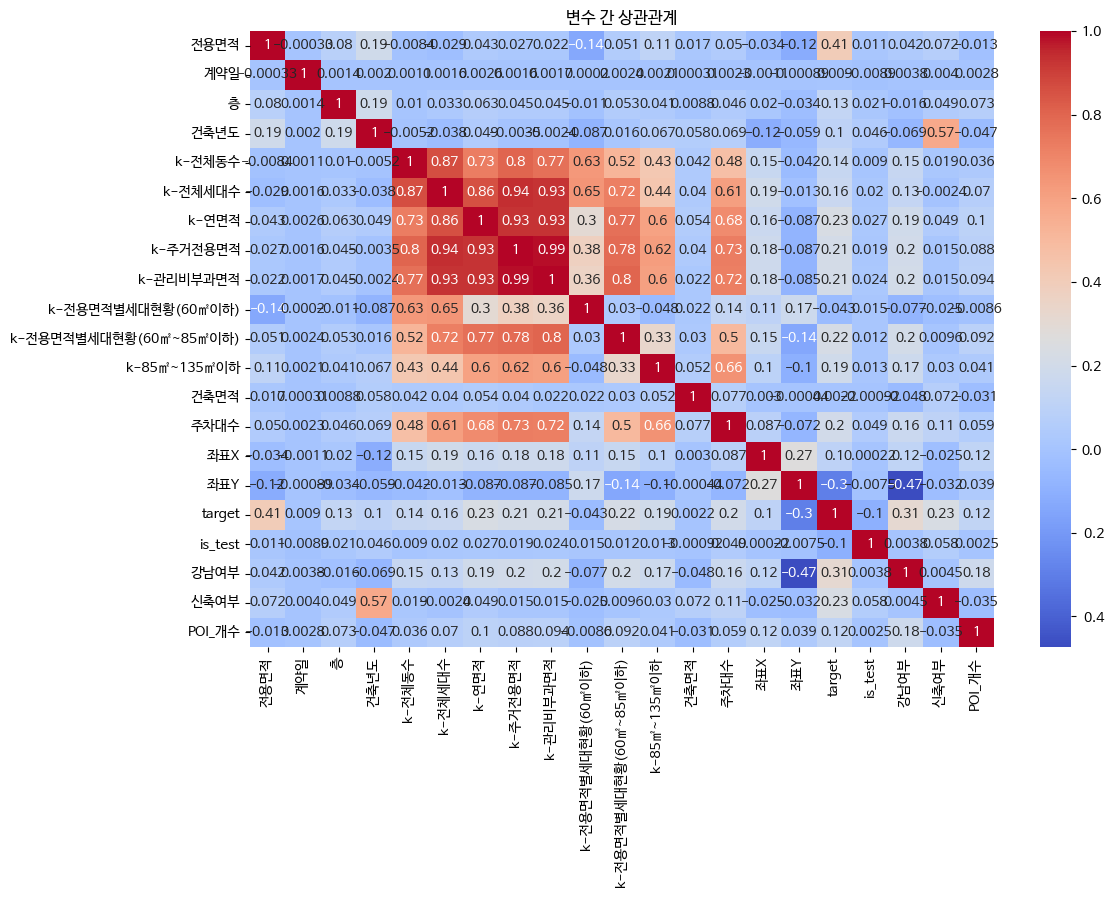

In [104]:
# 상관관계 행렬 계산
corr_matrix = concat_select.corr()

# 상관관계 히트맵 시각화
plt.figure(figsize=(12, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm')
plt.title('변수 간 상관관계')
plt.show()

### POI 개수
- 카카오 API를 활용하여 얻습니다.

In [64]:
# 지하철 데이터와 메인 데이터 좌표 확인
display(concat_select[['좌표Y', '좌표X']].head(1))

,좌표Y,좌표X
0,37.476763,127.05721


In [65]:
# def get_poi_total_count(latitude, longitude, radius, category_group_code=None):
#     url = 'https://dapi.kakao.com/v2/local/search/category.json'
#     headers = {
#         'Authorization': f'KakaoAK {KAKAO_API_KEY}'
#     }
#     params = {
#         'x': longitude,
#         'y': latitude,
#         'radius': radius,
#         'page': 1,
#         'size': 15,
#         'category_group_code': category_group_code
#     }

#     response = requests.get(url, headers=headers, params=params)
#     data = response.json()

#     if 'meta' in data:
#         total_count = data['meta']['total_count']
#         max_count = 45 * 15
#         if total_count > max_count:
#             total_count = max_count
#         return total_count
#     else:
#         print("API 요청 실패:", data)
#         return 0

In [66]:
# df_unique_YX = concat_select[['좌표Y', '좌표X']].drop_duplicates()

# print(df_unique_YX)

In [67]:
# poi_counts = []
# for _, row in tqdm(df_unique_YX.iterrows()):
#     latitude = row['좌표Y']
#     longitude = row['좌표X']
#     poi_count = get_poi_total_count(latitude, longitude, radius=1000, category_group_code=['MT1', 'SC4', 'AC5', 'SW8', 'AG2', 'HP8'])
#     poi_counts.append(poi_count)

# df_unique_YX['POI_개수'] = poi_counts
# print(df_unique_YX)

In [68]:
# df_unique_YX.to_csv('../unique_YX_poi.csv', index=False)

In [69]:
unique_YX_poi_path = '/data/ephemeral/home/unique_YX_poi.csv'
df_unique_YX = pd.read_csv(unique_YX_poi_path)

In [70]:
display(df_unique_YX.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8345 entries, 0 to 8344
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   좌표Y     8345 non-null   float64
 1   좌표X     8345 non-null   float64
 2   POI_개수  8345 non-null   int64  
dtypes: float64(2), int64(1)
memory usage: 195.7 KB


None

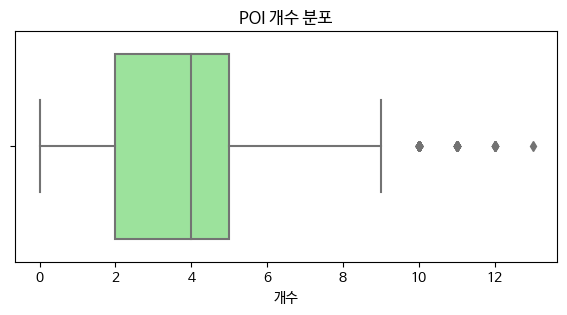

In [71]:
# 대표적인 연속형 변수인 “POI_개수” 변수 관련한 분포를 먼저 살펴보도록 하겠습니다.
fig = plt.figure(figsize=(7, 3))
sns.boxplot(data = df_unique_YX, x = "POI_개수", color="lightgreen")
plt.title("POI 개수 분포")
plt.xlabel('개수')
plt.show()

In [72]:
# 메인 데이터프레임과 서브 데이터프레임 병합
concat_select = pd.merge(concat_select, df_unique_YX, on=['좌표Y', '좌표X'], how='left')

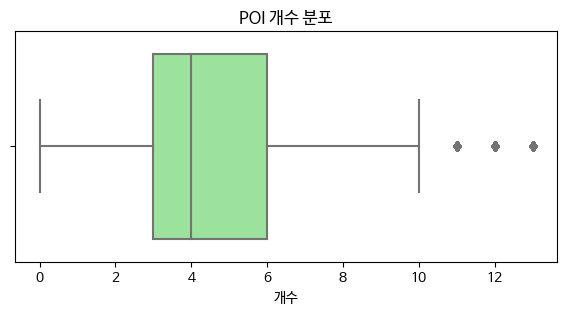

In [73]:
# 대표적인 연속형 변수인 “전용 면적” 변수 관련한 분포를 먼저 살펴보도록 하겠습니다.
fig = plt.figure(figsize=(7, 3))
sns.boxplot(data = concat_select, x = "POI_개수", color="lightgreen")
plt.title("POI 개수 분포")
plt.xlabel('개수')
plt.show()

In [74]:
# 위 방법으로 전용 면적에 대한 이상치를 제거해보겠습니다.
concat_select = remove_outliers_iqr(concat_select, 'POI_개수')

In [75]:
print(concat_select.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1033789 entries, 0 to 1038845
Data columns (total 50 columns):
 #   Column                  Non-Null Count    Dtype  
---  ------                  --------------    -----  
 0   번지                      1033789 non-null  object 
 1   본번                      1033789 non-null  object 
 2   부번                      1033789 non-null  object 
 3   아파트명                    1033789 non-null  object 
 4   전용면적                    1033789 non-null  float64
 5   계약일                     1033789 non-null  int64  
 6   층                       1033789 non-null  int64  
 7   건축년도                    1033789 non-null  int64  
 8   도로명                     1033789 non-null  object 
 9   k-단지분류(아파트,주상복합등등)      1033789 non-null  object 
 10  k-전화번호                  1033789 non-null  object 
 11  k-팩스번호                  1033789 non-null  object 
 12  k-세대타입(분양형태)            1033789 non-null  object 
 13  k-관리방식                  1033789 non-null  object 
 14  k-

## 5. Model Training

- 이제 위에서 만든 파생변수들과 정제한 데이터를 기반으로 본격적으로 부동산 실거래가를 예측하는 모델링을 진행하겠습니다.
- 모델링에는 `sklearn`의 `RandomForest`를 이용하도록 하겠습니다.

- 참고 ✅
  - `RandomForest`는 배깅(Bagging)의 일종으로, 학습시키는 데이터 뿐 아니라 특성변수(X)들도 무작위로 선택해 트리를 생성하는 방법입니다.
  - 모델 학습 과정에서 서로 다른 N개의 Tree 생성하고, N개의 Tree에서 발생한 Output을 Voting(범주형, 분류문제)하거나, Average(연속형, 회귀문제)해 최종 Output 생성합니다.
  - 이는 High variance, Low bias 상황에서 분산(Variance) 감소에 도움을 줍니다.

In [76]:
# 이제 다시 train과 test dataset을 분할해줍니다. 위에서 제작해 놓았던 is_test 칼럼을 이용합니다.
dt_train = concat_select.query('is_test==0')
dt_test = concat_select.query('is_test==1')

# 이제 is_test 칼럼은 drop해줍니다.
dt_train.drop(['is_test'], axis = 1, inplace=True)
dt_test.drop(['is_test'], axis = 1, inplace=True)
print(dt_train.shape, dt_test.shape)

(1024517, 49) (9272, 49)


In [77]:
concat_select.columns

Index(['번지', '본번', '부번', '아파트명', '전용면적', '계약일', '층', '건축년도', '도로명',
       'k-단지분류(아파트,주상복합등등)', 'k-전화번호', 'k-팩스번호', 'k-세대타입(분양형태)', 'k-관리방식',
       'k-복도유형', 'k-난방방식', 'k-전체동수', 'k-전체세대수', 'k-건설사(시공사)', 'k-시행사',
       'k-사용검사일-사용승인일', 'k-연면적', 'k-주거전용면적', 'k-관리비부과면적', 'k-전용면적별세대현황(60㎡이하)',
       'k-전용면적별세대현황(60㎡~85㎡이하)', 'k-85㎡~135㎡이하', 'k-수정일자', '고용보험관리번호',
       '경비비관리형태', '세대전기계약방법', '청소비관리형태', '건축면적', '주차대수', '기타/의무/임대/임의=1/2/3/4',
       '단지승인일', '사용허가여부', '관리비 업로드', '좌표X', '좌표Y', '단지신청일', 'target',
       'is_test', '구', '동', '계약년', '계약월', '강남여부', '신축여부', 'POI_개수'],
      dtype='object')

In [78]:
# dt_test의 target은 일단 0으로 임의로 채워주도록 하겠습니다.
dt_test['target'] = 0

### 5.1. 범주형 변수 Encoding
- 범주형 변수는 그대로 모델에 투입하면, 모델이 제대로 작동할 수 없습니다.
- 따라서 **레이블 인코딩 과정**을 통해 범주형 변수들을 numeric하게 바꾸는 인코딩 과정을 진행해주도록 하겠습니다.

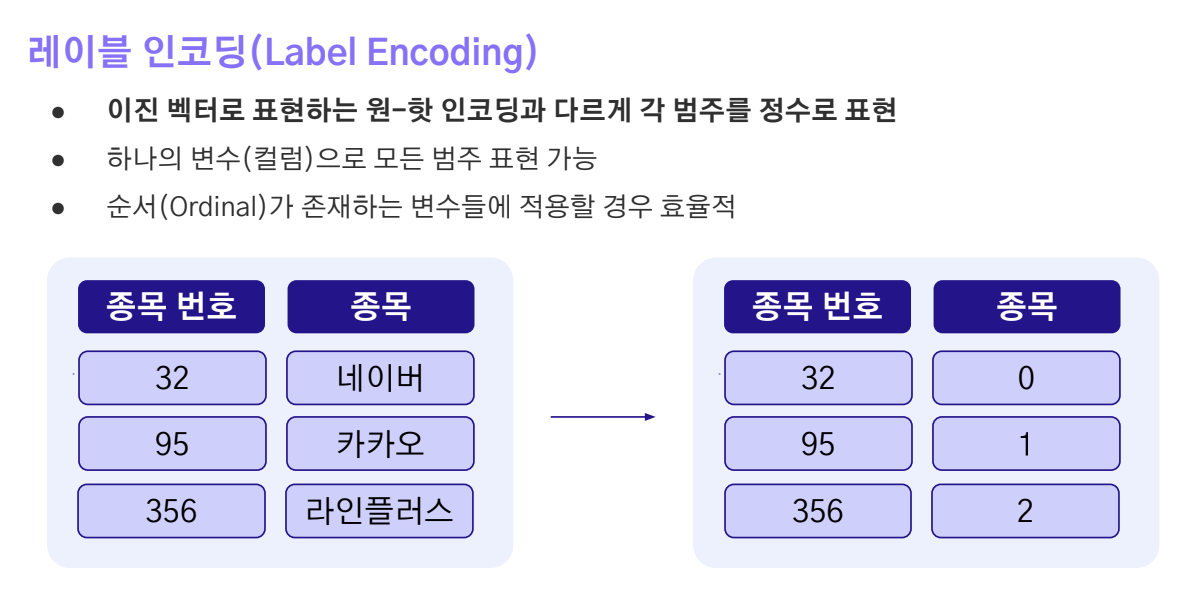

In [79]:
dt_train['좌표Y'] = dt_train['좌표Y'].astype(float)
dt_train['좌표X'] = dt_train['좌표X'].astype(float)

In [80]:
# 파생변수 제작으로 추가된 변수들이 존재하기에, 다시한번 연속형과 범주형 칼럼을 분리해주겠습니다.
continuous_columns_v2 = []
categorical_columns_v2 = []

for column in dt_train.columns:
    if pd.api.types.is_numeric_dtype(dt_train[column]):
        continuous_columns_v2.append(column)
    else:
        categorical_columns_v2.append(column)

print("연속형 변수:", continuous_columns_v2)
print("범주형 변수:", categorical_columns_v2)

연속형 변수: ['전용면적', '계약일', '층', '건축년도', 'k-전체동수', 'k-전체세대수', 'k-연면적', 'k-주거전용면적', 'k-관리비부과면적', 'k-전용면적별세대현황(60㎡이하)', 'k-전용면적별세대현황(60㎡~85㎡이하)', 'k-85㎡~135㎡이하', '건축면적', '주차대수', '좌표X', '좌표Y', 'target', '강남여부', '신축여부', 'POI_개수']
범주형 변수: ['번지', '본번', '부번', '아파트명', '도로명', 'k-단지분류(아파트,주상복합등등)', 'k-전화번호', 'k-팩스번호', 'k-세대타입(분양형태)', 'k-관리방식', 'k-복도유형', 'k-난방방식', 'k-건설사(시공사)', 'k-시행사', 'k-사용검사일-사용승인일', 'k-수정일자', '고용보험관리번호', '경비비관리형태', '세대전기계약방법', '청소비관리형태', '기타/의무/임대/임의=1/2/3/4', '단지승인일', '사용허가여부', '관리비 업로드', '단지신청일', '구', '동', '계약년', '계약월']


In [81]:
# 아래에서 범주형 변수들을 대상으로 레이블인코딩을 진행해 주겠습니다.

# 각 변수에 대한 LabelEncoder를 저장할 딕셔너리
label_encoders = {}

# Implement Label Encoding
for col in tqdm( categorical_columns_v2 ):
    lbl = LabelEncoder()

    # Label-Encoding을 fit
    lbl.fit( dt_train[col].astype(str) )
    dt_train[col] = lbl.transform(dt_train[col].astype(str))
    label_encoders[col] = lbl           # 나중에 후처리를 위해 레이블인코더를 저장해주겠습니다.

    # Test 데이터에만 존재하는 새로 출현한 데이터를 신규 클래스로 추가해줍니다.
    for label in np.unique(dt_test[col]):
      if label not in lbl.classes_: # unseen label 데이터인 경우
        lbl.classes_ = np.append(lbl.classes_, label) # 미처리 시 ValueError발생하니 주의하세요!

    dt_test[col] = lbl.transform(dt_test[col].astype(str))

  0%|          | 0/29 [00:00<?, ?it/s]

100%|██████████| 29/29 [00:08<00:00,  3.55it/s]


In [82]:
dt_train.head(1)        # 레이블인코딩이 된 모습입니다.

,번지,본번,부번,아파트명,전용면적,계약일,층,건축년도,도로명,"k-단지분류(아파트,주상복합등등)",...,좌표Y,단지신청일,target,구,동,계약년,계약월,강남여부,신축여부,POI_개수
0,4264,1110,1,292,79.97,8,3,1987,5496,3,...,37.476763,240,124000.0,0,8,10,11,1,0,3


### 5.2. Model Training
- 위 데이터를 이용해 모델을 train 해보겠습니다. 모델은 RandomForest를 이용하겠습니다.
- Train과 Valid dataset을 분할하는 과정에서는 `holdout` 방법을 사용하겠습니다. 이 방법의 경우  대략적인 성능을 빠르게 확인할 수 있다는 점에서 baseline에서 사용해보도록 하겠습니다.
  - 이 후 추가적인 eda를 통해서 평가세트와 경향을 맞추거나 kfold와 같은 분포에 대한 고려를 추가할 수 있습니다.

In [83]:
assert dt_train.shape[1] == dt_test.shape[1]          # train/test dataset의 shape이 같은지 확인해주겠습니다.

In [84]:
# Target과 독립변수들을 분리해줍니다.
y_train = dt_train['target']
X_train = dt_train.drop(['target'], axis=1)

# Hold out split을 사용해 학습 데이터와 검증 데이터를 8:2 비율로 나누겠습니다.
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=2023)

In [85]:
# RandomForestRegressor를 이용해 회귀 모델을 적합시키겠습니다.
model = RandomForestRegressor(n_estimators=5, criterion='squared_error', random_state=1, n_jobs=-1)
model.fit(X_train, y_train)
pred = model.predict(X_val)

- 랜덤포레스트의 하이퍼파라미터도 데이터에 맞게 지정해줄 수 있습니다. 데이터에 맞는 하이퍼파라미터를 찾는 것도 성능 향상에 도움이 될 수 있습니다.

In [86]:
# 회귀 관련 metric을 통해 train/valid의 모델 적합 결과를 관찰합니다.
print(f'RMSE test: {np.sqrt(metrics.mean_squared_error(y_val, pred))}')

RMSE test: 5386.497334372673


- 변수 중요도도 확인해보도록 하겠습니다.

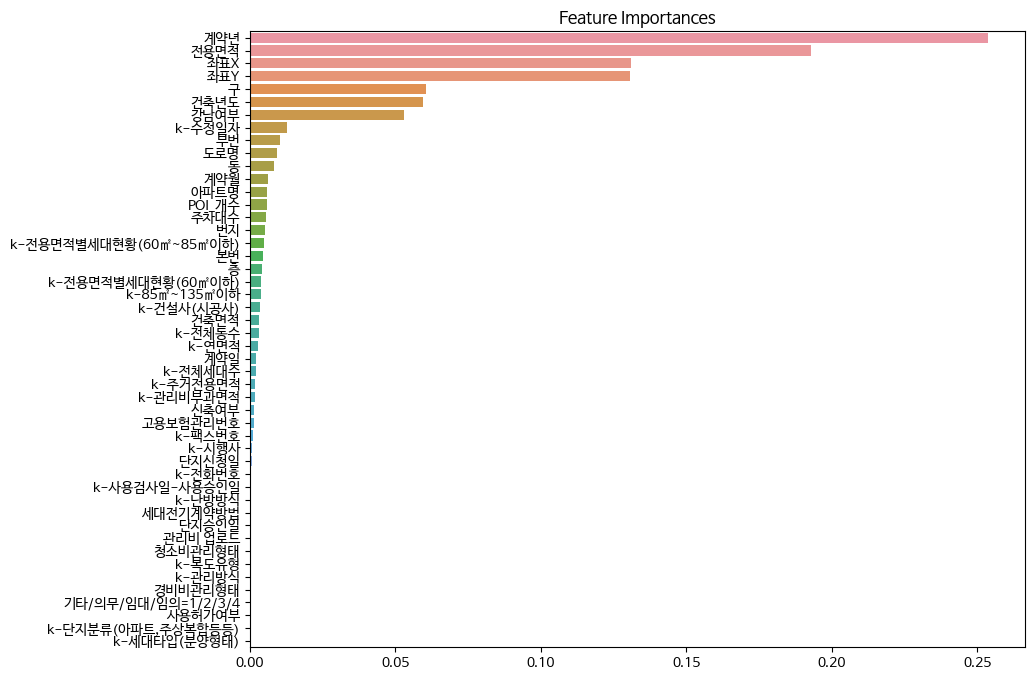

In [87]:
# 위 feature importance를 시각화해봅니다.
importances = pd.Series(model.feature_importances_, index=list(X_train.columns))
importances = importances.sort_values(ascending=False)

plt.figure(figsize=(10,8))
plt.title("Feature Importances")
sns.barplot(x=importances, y=importances.index)
plt.show()

In [88]:
# 학습된 모델을 저장합니다. Pickle 라이브러리를 이용하겠습니다.
with open('saved_model.pkl', 'wb') as f:
    pickle.dump(model, f)

### 5.3. Feature selection

- 어떤 변수가 유용한 변수인지 확인해보기 위해 permutation selection을 이용해보겠습니다.

In [89]:
# Permutation importance 방법을 변수 선택에 이용해보겠습니다.
perm = PermutationImportance(model,        # 위에서 학습된 모델을 이용하겠습니다.
                             scoring = "neg_mean_squared_error",        # 평가 지표로는 회귀문제이기에 negative rmse를 사용합니다. (neg_mean_squared_error : 음의 평균 제곱 오차)
                             random_state = 42,
                             n_iter=3).fit(X_val, y_val)
eli5.show_weights(perm, feature_names = X_val.columns.tolist())    # valid data에 대해 적합시킵니다.

Weight,Feature
892608713.5455 ± 7732948.3837,계약년
535704653.7862 ± 2576668.8711,좌표Y
497973203.1413 ± 6744976.4333,전용면적
427211358.9515 ± 4732476.6303,좌표X
288626799.3900 ± 2727382.0289,강남여부
219611051.8686 ± 7888161.9696,구
188410221.0963 ± 2152669.1214,건축년도
33663319.1293 ± 474743.1245,부번
32126325.4451 ± 992974.5639,도로명
26674920.3541 ± 431988.1749,동


- 분석 결과 "계약년", "전용면적" 변수가 유의한 변수로 보입니다. 따라서 이 변수로 또 다른 파생변수를 더 생성해보거나, 중요도가 낮아보이는 변수를 제거해 차원의 저주를 막아볼 수도 있습니다.

### 5.4. Valid prediction 분석

- 예측값을 분석해보기 위해 valid prediction을 확인해보겠습니다.

In [90]:
# Validation dataset에 target과 pred 값을 채워주도록 하겠습니다.
X_val['target'] = y_val
X_val['pred'] = pred

In [91]:
# Squared_error를 계산하는 함수를 정의하겠습니다.
def calculate_se(target, pred):
    squared_errors = (target - pred) ** 2
    return squared_errors

# RMSE 계산
squared_errors = calculate_se(X_val['target'], X_val['pred'])
X_val['error'] = squared_errors

In [92]:
# Error가 큰 순서대로 sorting 해 보겠습니다.
X_val_sort = X_val.sort_values(by='error', ascending=False)       # 내림차순 sorting

In [93]:
X_val_sort.head()

,번지,본번,부번,아파트명,전용면적,계약일,층,건축년도,도로명,"k-단지분류(아파트,주상복합등등)",...,구,동,계약년,계약월,강남여부,신축여부,POI_개수,target,pred,error
197322,4447,1156,1,5321,115.0000,7,12,1987,3927,0,...,14,111,16,5,1,0,6,140000.0,271000.0,1.716100e+10
215045,5827,1461,0,3037,102.8617,19,11,2020,4223,0,...,20,305,15,3,0,1,4,200500.0,331156.0,1.707099e+10
355846,1467,549,0,301,41.9900,26,1,1982,3952,0,...,0,8,12,0,1,0,5,137000.0,261800.0,1.557504e+10
654068,5237,1282,0,5469,91.5100,25,3,1984,5022,0,...,14,111,8,6,1,0,2,210000.0,85500.0,1.550025e+10
213616,5438,1363,0,3890,83.0600,7,12,1988,5270,0,...,17,113,15,3,1,0,2,239000.0,120500.0,1.404225e+10


- 예측을 잘 하지 못한 top 100개의 데이터와 예측을 잘한 top 100개의 데이터를 비교해보겠습니다.

In [94]:
X_val_sort_top100 = X_val.sort_values(by='error', ascending=False).head(100)        # 예측을 잘 하지못한 top 100개의 data
X_val_sort_tail100 = X_val.sort_values(by='error', ascending=False).tail(100)       # 예측을 잘한 top 100개의 data

In [95]:
# 해석을 위해 레이블인코딩 된 변수를 복원해줍니다.
error_top100 = X_val_sort_top100.copy()
for column in categorical_columns_v2 :     # 앞서 레이블 인코딩에서 정의했던 categorical_columns_v2 범주형 변수 리스트를 사용합니다.
    error_top100[column] = label_encoders[column].inverse_transform(X_val_sort_top100[column])

best_top100 = X_val_sort_tail100.copy()
for column in categorical_columns_v2 :     # 앞서 레이블 인코딩에서 정의했던 categorical_columns_v2 범주형 변수 리스트를 사용합니다.
    best_top100[column] = label_encoders[column].inverse_transform(X_val_sort_tail100[column])

In [96]:
display(error_top100.head(1))
display(best_top100.head(1))

,번지,본번,부번,아파트명,전용면적,계약일,층,건축년도,도로명,"k-단지분류(아파트,주상복합등등)",...,구,동,계약년,계약월,강남여부,신축여부,POI_개수,target,pred,error
197322,70-1,70.0,1.0,한신서래,115.0,7,12,1987,사평대로28길 31,NULL,...,서초구,반포동,2023,06,1,0,6,140000.0,271000.0,1.716100e+10


,번지,본번,부번,아파트명,전용면적,계약일,층,건축년도,도로명,"k-단지분류(아파트,주상복합등등)",...,구,동,계약년,계약월,강남여부,신축여부,POI_개수,target,pred,error
678188,1259,1259.0,0.0,신트리1,49.8,22,10,1999,신정로 293,NULL,...,양천구,신정동,2015,06,0,0,5,23800.0,23800.0,0.0


- 이제 분포를 비교해보도록 하겠습니다.

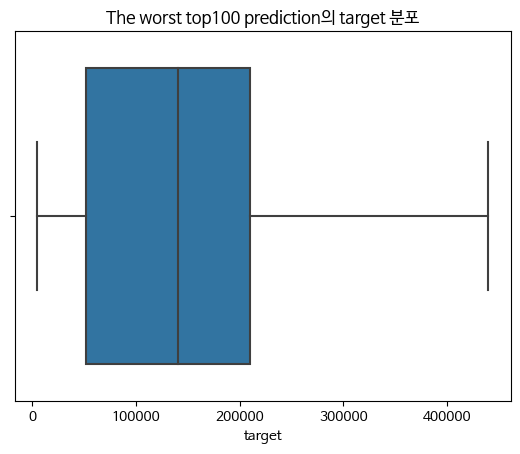

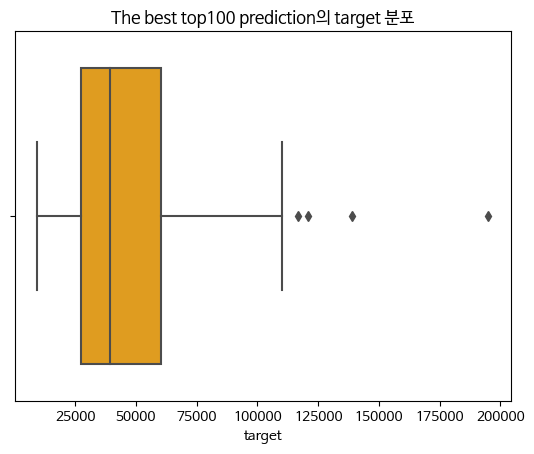

In [97]:
sns.boxplot(data = error_top100, x='target')
plt.title('The worst top100 prediction의 target 분포')
plt.show()

sns.boxplot(data = best_top100, x='target', color='orange')
plt.title('The best top100 prediction의 target 분포')
plt.show()

- Taget 분포를 보니 좋은 예측을 보인 top 100개의 data보다 상대적으로 나쁜 예측을 보인 top 100 dataset들이 높은 가격을 보였음을 확인할 수 있습니다. 이에 대한 모델링 및 처리가 필요해보입니다.

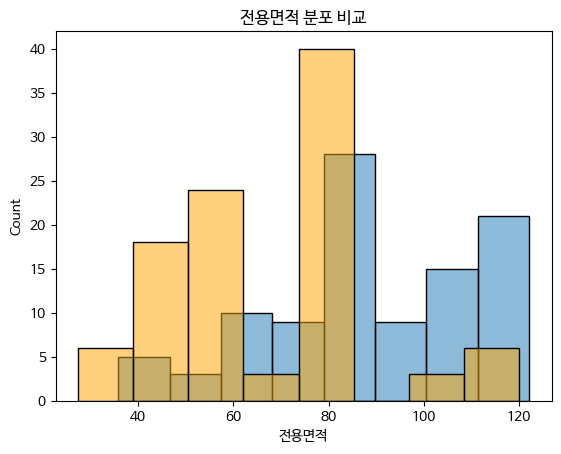

In [98]:
sns.histplot(data = error_top100, x='전용면적', alpha=0.5)
sns.histplot(data = best_top100, x='전용면적', color='orange', alpha=0.5)
plt.title('전용면적 분포 비교')
plt.show()

- 전용면적 또한 나쁜 예측을 보인 집들이 더 넓음을 확인할 수 있습니다.

## 6. Inference

In [99]:
dt_test.head(2)      # test dataset에 대한 inference를 진행해보겠습니다.

,번지,본번,부번,아파트명,전용면적,계약일,층,건축년도,도로명,"k-단지분류(아파트,주상복합등등)",...,좌표Y,단지신청일,target,구,동,계약년,계약월,강남여부,신축여부,POI_개수
1029574,4264,1110,1,292,79.9700,26,5,1987,5496,3,...,37.476763,240,0,0,8,16,6,1,0,3
1029575,4240,1103,1,293,108.2017,15,10,2021,431,3,...,37.484892,236,0,0,8,16,7,1,1,4


In [100]:
# 저장된 모델을 불러옵니다.
with open('saved_model.pkl', 'rb') as f:
    model = pickle.load(f)

In [101]:
%%time
X_test = dt_test.drop(['target'], axis=1)

# Test dataset에 대한 inference를 진행합니다.
real_test_pred = model.predict(X_test)

CPU times: user 21.4 ms, sys: 0 ns, total: 21.4 ms
Wall time: 17.1 ms


In [102]:
real_test_pred          # 예측값들이 출력됨을 확인할 수 있습니다.

array([202040., 308600., 250400., ...,  66400.,  61400.,  66900.])

## 7. Output File Save

In [103]:
# 앞서 예측한 예측값들을 저장합니다.
preds_df = pd.DataFrame(real_test_pred.astype(int), columns=["target"])
preds_df.to_csv('output.csv', index=False)